# Data Preprocessing

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
# Read the original CSV file
input_file = 'data.csv'
df = pd.read_csv(input_file)

# Transform non-numeric data to numeric using label encoding
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].astype('category').cat.codes

# Randomly shuffle the data
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate the split index
split_index = int(len(df_shuffled) * 0.80)

# Split the data
df_train = df_shuffled.iloc[:split_index]
df_test = df_shuffled.iloc[split_index:]

# Save the split data to new CSV files
train_file = 'train.csv'
test_file = 'test.csv'
df_train.to_csv(train_file, index=False)
df_test.to_csv(test_file, index=False)

In [3]:
# Load the training and testing data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Separate x(features) and y(labels)
x_train = train.drop(['totalFare', 'baseFare'], axis=1)
y_train = train['totalFare']
x_test = test.drop(['totalFare', 'baseFare'], axis=1)
y_test = test['totalFare']

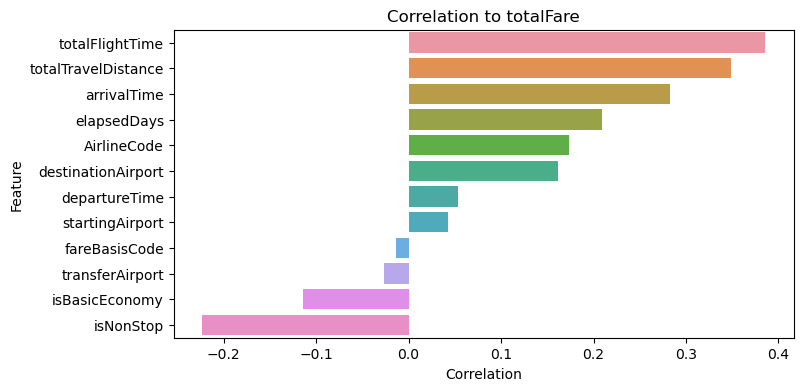

In [4]:
# Calculate and plot the correlation of features with 'totalFare'
features = train.drop(['totalFare', 'baseFare'], axis=1)
correlation = features.corrwith(train['totalFare'])
correlation = correlation.sort_values(ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(data=correlation.reset_index(), y='index', x=0, orient='h')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.title('Correlation to totalFare')
plt.show()

# Decision Tree

In [5]:
class DecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2):
        # Initialize the decision tree with maximum depth and minimum samples to split
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def fit(self, X, y):
        # Fit the model to the training data
        self.tree = self.build_tree(X, y, depth=0)

    def build_tree(self, X, y, depth):
        # Build the tree recursively
        if depth == self.max_depth or len(X) <= self.min_samples_split:
            # If max depth is reached or too few samples, return the mean value
            return np.mean(y)

        num_features = X.shape[1]
        best_feature, best_threshold, best_loss = None, None, float('inf')

        # Find the best feature and threshold to split on
        for feature_idx in range(num_features):
            thresholds = np.unique(X.iloc[:, feature_idx])
            for threshold in thresholds:
                left_indices = X.iloc[:, feature_idx] < threshold
                right_indices = ~left_indices
                left_y = y[left_indices]
                right_y = y[right_indices]
                if len(left_y) < self.min_samples_split or len(right_y) < self.min_samples_split:
                    continue
                loss = self.calculate_loss(left_y) + self.calculate_loss(right_y)
                if loss < best_loss:
                    best_feature = feature_idx
                    best_threshold = threshold
                    best_loss = loss

        if best_feature is None:
            # If no valid feature is found, return the mean value
            return np.mean(y)

        # Recursively build the left and right subtrees
        left_indices = X.iloc[:, best_feature] < best_threshold
        right_indices = ~left_indices
        left_tree = self.build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self.build_tree(X[right_indices], y[right_indices], depth + 1)

        return (best_feature, best_threshold, left_tree, right_tree)

    def predict(self, X):
        # Predict the target for each sample in X
        return np.array([self.predict_tree(x, self.tree) for _, x in X.iterrows()])

    def predict_tree(self, x, tree):
        # Recursively predict the target for a single sample using the tree
        if isinstance(tree, (int, float)):
            return tree
        feature, threshold, left_tree, right_tree = tree
        if x.iloc[feature] < threshold:
            return self.predict_tree(x, left_tree)
        else:
            return self.predict_tree(x, right_tree)

    def calculate_loss(self, y):
        # Calculate the mean squared error (loss)
        return np.mean((y - np.mean(y))**2)

In [6]:
# Train the Decision Tree model
dt_model = DecisionTreeRegressor(max_depth=None, min_samples_split=5)
dt_model.fit(x_train, y_train)

# Save the Decision Tree model
with open('dt_model.pkl', 'wb') as f:
    pickle.dump(dt_model, f)

# Make predictions
dt_predictions = dt_model.predict(x_test)

# Calculte RMSE
dt_rmse = np.sqrt(np.mean((y_test - dt_predictions) ** 2))
print("RMSE:", dt_rmse)

# Calculate R² score
y_mean = np.mean(y_test)
total_sum_of_squares = np.sum((y_test - y_mean) ** 2)
residual_sum_of_squares = np.sum((y_test - dt_predictions) ** 2)
dt_r2score = 1 - (residual_sum_of_squares / total_sum_of_squares)
print("R² score:", dt_r2score)

# Calculate accuracy
dt_accuracy = np.mean(abs(dt_predictions - y_test) < 50) * 100
print("Accuracy:", dt_accuracy, "%")

RMSE: 154.64495591166593
R² score: 0.49395996907805195
Accuracy: 53.806781829814454 %


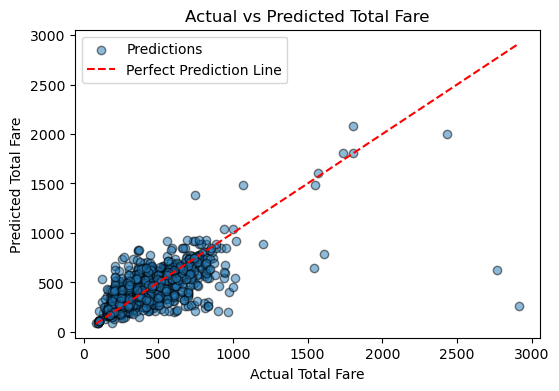

In [7]:
# Plotting the results
plt.figure(figsize=(6, 4))
plt.scatter(y_test, dt_predictions, alpha=0.5, edgecolors='k', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')
plt.xlabel('Actual Total Fare')
plt.ylabel('Predicted Total Fare')
plt.title('Actual vs Predicted Total Fare')
plt.legend()
plt.show()

# Random Forest

In [8]:
class RandomForestRegressor:
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, random_state=None):
        # Initialize the random forest with the given parameters
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        # Train the random forest
        np.random.seed(self.random_state)
        for i in range(self.n_estimators):
            # Create bootstrap samples
            idx = np.random.choice(len(X), len(X), replace=True)
            X_bootstrap = X.iloc[idx]
            y_bootstrap = y.iloc[idx]
            # Train a decision tree on the bootstrap sample
            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)

    def predict(self, X):
        # Predict the target for each sample in X using the ensemble of trees
        predictions = np.zeros(len(X))
        for tree in self.trees:
            predictions += tree.predict(X)
        return predictions / self.n_estimators

In [9]:
# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators = 50, max_depth=None, min_samples_split=2, random_state=42)
rf_model.fit(x_train, y_train)

# Save the Random Forest model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Make predictions
rf_predictions = rf_model.predict(x_test)

# Calculte RMSE
rf_rmse = np.sqrt(np.mean((y_test - rf_predictions) ** 2))
print("RMSE:", rf_rmse)

# Calculate R² score
y_mean = np.mean(y_test)
total_sum_of_squares = np.sum((y_test - y_mean) ** 2)
residual_sum_of_squares = np.sum((y_test - rf_predictions) ** 2)
rf_r2score = 1 - (residual_sum_of_squares / total_sum_of_squares)
print("R² score:", rf_r2score)

# Calculate accuracy
rf_accuracy = np.mean(abs(rf_predictions - y_test) < 50) * 100
print("Accuracy:", rf_accuracy, "%")

RMSE: 127.68198368653677
R² score: 0.6550369348689498
Accuracy: 61.228406909788866 %


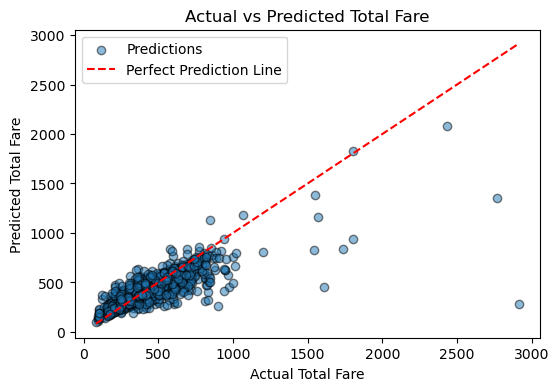

In [10]:
# Plotting the results
plt.figure(figsize=(6, 4))
plt.scatter(y_test, rf_predictions, alpha=0.5, edgecolors='k', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')
plt.xlabel('Actual Total Fare')
plt.ylabel('Predicted Total Fare')
plt.title('Actual vs Predicted Total Fare')
plt.legend()
plt.show()

# Gradient Boosting

In [11]:
class GradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=None, min_samples_split=2, subsample=1.0, random_state=None):
        # Initialize the gradient boosting model with the given parameters
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.subsample = subsample
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        # Train the gradient boosting model
        np.random.seed(self.random_state)
        self.initial_prediction = np.mean(y)
        self.trees = []

        # Initial prediction (mean of y)
        current_predictions = np.full_like(y, self.initial_prediction, dtype=np.float64)

        for i in range(self.n_estimators):
            # Calculate residuals
            residuals = y - current_predictions

            # Subsample the data if subsample rate is less than 1.0
            if self.subsample < 1.0:
                indices = np.random.choice(np.arange(len(y)), size=int(len(y) * self.subsample), replace=False)
                X_subset = X.iloc[indices]
                residuals_subset = residuals[indices]
            else:
                X_subset = X
                residuals_subset = residuals

            # Train a new decision tree on the residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_subset, residuals_subset)
            self.trees.append(tree)

            # Update the current predictions
            predictions = tree.predict(X)
            current_predictions += self.learning_rate * predictions

    def predict(self, X):
        # Predict the target for each sample in X using the ensemble of trees
        predictions = np.full((X.shape[0],), self.initial_prediction, dtype=np.float64)
        for i, tree in enumerate(self.trees):
            predictions += self.learning_rate * tree.predict(X)
        return predictions

In [12]:
# Train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators = 50, learning_rate=0.2, max_depth=None, min_samples_split=2, subsample=0.8, random_state=42)
gb_model.fit(x_train, y_train)

# Save the Gradient Boosting model
with open('gb_model.pkl', 'wb') as f:
    pickle.dump(gb_model, f)

# Make predictions
gb_predictions = gb_model.predict(x_test)

# Calculte RMSE
gb_rmse = np.sqrt(np.mean((y_test - gb_predictions) ** 2))
print("RMSE:", gb_rmse)

# Calculate R² score 
y_mean = np.mean(y_test)
total_sum_of_squares = np.sum((y_test - y_mean) ** 2)
residual_sum_of_squares = np.sum((y_test - gb_predictions) ** 2)
gb_r2score = 1 - (residual_sum_of_squares / total_sum_of_squares)
print("R² score:", gb_r2score)

# Calculate accuracy
gb_accuracy = np.mean(abs(gb_predictions - y_test) < 50) * 100
print("Accuracy:", gb_accuracy, "%")

RMSE: 119.30057359567645
R² score: 0.6988392160832606
Accuracy: 69.80166346769033 %


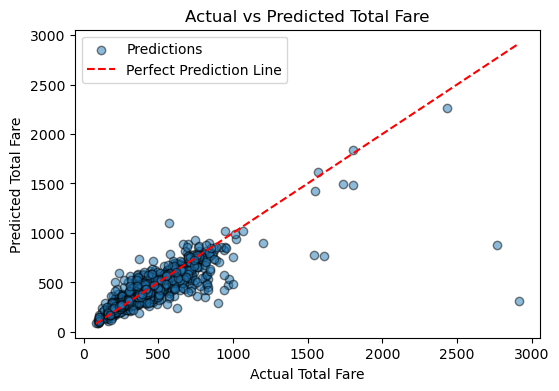

In [13]:
# Plotting the results
plt.figure(figsize=(6, 4))
plt.scatter(y_test, gb_predictions, alpha=0.5, edgecolors='k', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')
plt.xlabel('Actual Total Fare')
plt.ylabel('Predicted Total Fare')
plt.title('Actual vs Predicted Total Fare')
plt.legend()
plt.show()

# Predicting Results

In [16]:
# Read the original CSV file
input_file = 'data.csv'
df = pd.read_csv(input_file)

# Randomly select one row
random_row = df.sample(n=1)

# Print the selected row
print("Selected row:")
print(random_row)
print()

# Transform non-numeric data to numeric using label encoding for the selected row
for column in random_row.columns:
    if random_row[column].dtype == 'object':
        # Note: use the same categories as used for the entire dataset
        random_row[column] = random_row[column].astype('category').cat.codes

# Remove the target columns from the selected row for prediction
x_random = random_row.drop(['totalFare', 'baseFare'], axis=1)

# Load the models
with open('dt_model.pkl', 'rb') as f:
    dt_model_loaded = pickle.load(f)
with open('rf_model.pkl', 'rb') as f:
    rf_model_loaded = pickle.load(f)
with open('gb_model.pkl', 'rb') as f:
    gb_model_loaded = pickle.load(f)
    
# Predict the totalFare
dt_predicted = dt_model_loaded.predict(x_random)
rf_predicted = rf_model_loaded.predict(x_random)
gb_predicted = gb_model_loaded.predict(x_random)

# Output the prediction results
print("Predicted totalFare:")
print("Decision Tree:", dt_predicted[0])
print("Random Forest:", rf_predicted[0])
print("Gradient Boosting", gb_predicted[0])

Selected row:
     startingAirport destinationAirport  isBasicEconomy  isNonStop  \
3342             EWR                SFO           False      False   

     AirlineCode transferAirport  departureTime  arrivalTime  totalFlightTime  \
3342  UA||DL||DL        DCA||MSP     1650222000   1650263340            29760   

      elapsedDays  totalTravelDistance fareBasisCode  baseFare  totalFare  
3342            0                 2725      HAA0AFEN    536.74      605.1  

Predicted totalFare:
Decision Tree: 514.09
Random Forest: 648.3927333333336
Gradient Boosting 550.4990379737137
